In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

model_path = '/content/effnet_finetuned.keras'
img_size = (384, 384)
last_conv_layer_name = "post_conv"
class_labels_file = 'labels.txt'

def load_and_preprocess_image(img_path, target_size):
    img = Image.open(img_path)
    img_tensor = tf.cast(np.array(img), tf.float32)
    img_tensor = tf.image.resize(img_tensor, target_size, method='nearest')
    img_tensor /= 255.0
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    return img_tensor

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds.numpy()

def save_and_display_gradcam(img_path, heatmap, preds, class_labels, cam_path="cam.jpg", alpha=0.4, target_size=(384, 384)):
    # Calculate softmax probabilities
    probs = np.exp(preds) / np.sum(np.exp(preds), axis=-1, keepdims=True)
    # Sort predictions to get top 3
    top_indices = np.argsort(probs[0])[::-1][:3]
    top_classes = [class_labels[index] for index in top_indices]
    top_probabilities = [probs[0, index] * 100 for index in top_indices]
    # Display the top 3 predictions
    for i, (cls, prob) in enumerate(zip(top_classes, top_probabilities)):
        print(f"{cls}, Probability: {prob:.2f}%")
    # Load and convert the original image
    img = Image.open(img_path).convert("RGB")

    # Resize the heatmap to match the specified target size
    heatmap_resized = Image.fromarray(np.uint8(255 * heatmap)).resize(target_size, Image.BILINEAR)

    # Apply a color map to the resized heatmap
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]  # Take only the RGB colors
    jet_heatmap = Image.fromarray(np.uint8(jet_colors[heatmap_resized] * 255), 'RGB')

    # Blend the heatmap with the original image resized to target size
    img_resized = img.resize(target_size, Image.BILINEAR)
    superimposed_img = Image.blend(img_resized, jet_heatmap, alpha)
    superimposed_img.save(cam_path)
    display(superimposed_img)
def process_image(img_path, model_path, img_size, last_conv_layer_name, class_labels_file, alpha=0.4):
    model = tf.keras.models.load_model(model_path)
    model.layers[-1].activation = None
    img_array = load_and_preprocess_image(img_path, target_size=img_size)
    heatmap, preds = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # Load class labels
    with open(class_labels_file, 'r') as f:
        class_labels = [label.strip() for label in f.readlines()]

    save_and_display_gradcam(img_path, heatmap, preds, class_labels, alpha=alpha, target_size=img_size)



n02110185-Siberian_husky, Probability: 51.87%
n02109961-Eskimo_dog, Probability: 28.12%
n02110063-malamute, Probability: 18.07%


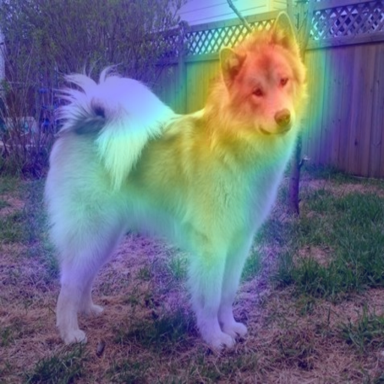

In [ ]:
img_path = 'eskimo_dog.jpg'
process_image(img_path, model_path, img_size, last_conv_layer_name, class_labels_file)

n02110185-Siberian_husky, Probability: 62.75%
n02109961-Eskimo_dog, Probability: 36.77%
n02110063-malamute, Probability: 0.24%


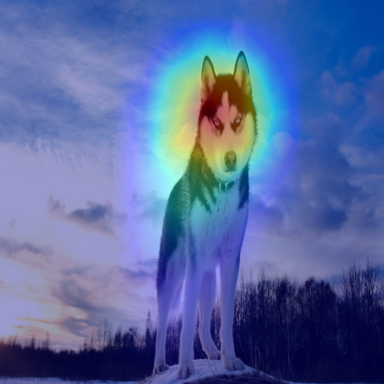

In [ ]:
img_path = 'Siberian_husky.jpeg'
process_image(img_path, model_path, img_size, last_conv_layer_name, class_labels_file)

n02113712-miniature_poodle, Probability: 79.48%
n02113624-toy_poodle, Probability: 17.17%
n02113799-standard_poodle, Probability: 2.88%


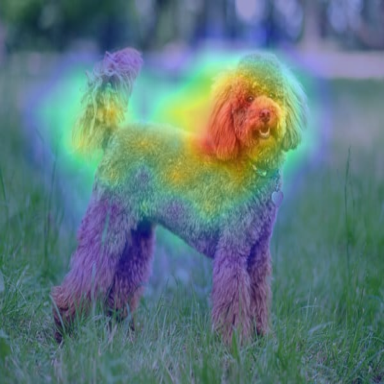

In [ ]:
img_path = 'toy_poodle.jpg'
process_image(img_path, model_path, img_size, last_conv_layer_name, class_labels_file)

n02113712-miniature_poodle, Probability: 53.84%
n02113624-toy_poodle, Probability: 43.78%
n02113799-standard_poodle, Probability: 1.81%


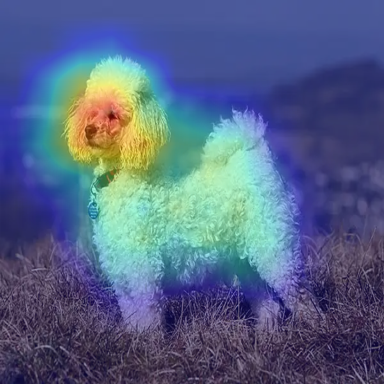

In [ ]:
img_path = 'miniature_poodle.jpg'
process_image(img_path, model_path, img_size, last_conv_layer_name, class_labels_file)